In [1]:
import sys
import os
script_dir = os.path.dirname(os.path.realpath('__file__'))
parent_dir = os.path.dirname(script_dir)
sys.path.insert(0, parent_dir)

import functions
import models
import gradcam
import pickle
from sklearn.model_selection import train_test_split
import torch
from torchvision import transforms
from torch.utils.data import Subset, DataLoader

In [2]:
# Use the GPU instead of the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Define the label maps
binary_labels_map = {
    0: "REAL",
    1: "FAKE"
}
with open(os.path.join(script_dir, '../../dataset/imagenet_classes.txt'), 'r') as file:
    labels = [line.strip() for line in file.readlines()]
multiclass_labels_map = {index: label for index, label in enumerate(labels)}

# Compose the transform that will be applied to the data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 324k samples for training
train_ds = functions.MulticlassGenImage(img_dir=os.path.join(script_dir, '../../dataset/stable_diffusion_1_4/train'), transform=transform)

# 6k samples for validation and 6k samples for testing
val_test_ds= functions.MulticlassGenImage(img_dir=os.path.join(script_dir, '../../dataset/stable_diffusion_1_4/val'), transform=transform)
# Perform a stratified split
stratify_labels = [f"{label['binary']}{label['multiclass']}" for label in val_test_ds.img_labels]
idx_val, idx_test = train_test_split(
    range(len(val_test_ds)),
    test_size=0.5,  # 50-50 split
    stratify=stratify_labels, # Uniform class distribution
    random_state=0
)
validation_ds = Subset(val_test_ds, idx_val)
test_ds = Subset(val_test_ds, idx_test)

cuda


# Untrained model



 - multiclass_untrained_batch64
Epoch 1: current lr = 1e-02
Train error: Combined=81.73%; Binary=12.00%; multiclass=80.38%; 
Validation error: Combined=85.03%; Binary=12.77%; multiclass=84.57%; 
Loss: 5.686e+00
Epoch 2: current lr = 1e-02
Train error: Combined=64.29%; Binary=7.63%; multiclass=61.16%; 
Validation error: Combined=73.95%; Binary=8.33%; multiclass=71.30%; 
Loss: 3.594e+00
Epoch 3: current lr = 1e-02
Train error: Combined=53.32%; Binary=5.03%; multiclass=50.78%; 
Validation error: Combined=67.67%; Binary=5.70%; multiclass=65.40%; 
Loss: 2.797e+00
Epoch 4: current lr = 1e-02
Train error: Combined=46.59%; Binary=4.03%; multiclass=44.35%; 
Validation error: Combined=64.87%; Binary=5.12%; multiclass=62.82%; 
Loss: 2.364e+00
Epoch 5: current lr = 1e-03
Train error: Combined=34.06%; Binary=1.55%; multiclass=33.11%; 
Validation error: Combined=59.32%; Binary=2.73%; multiclass=58.28%; 
Loss: 1.701e+00
Stopping training...


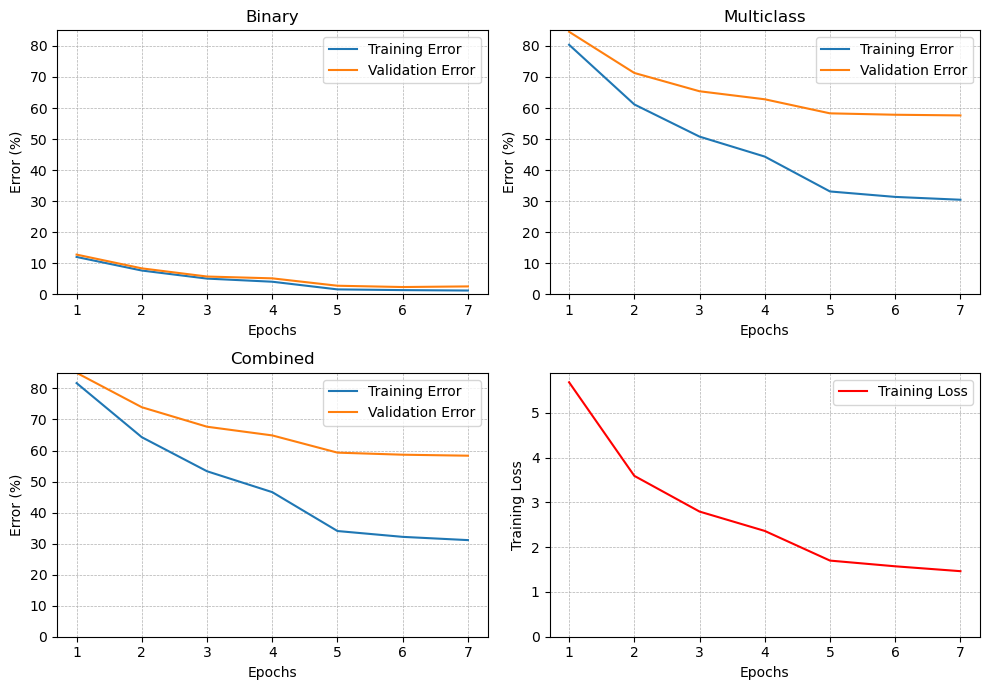

In [3]:
model_init_function = models.multiclass_untrained
epochs = 20
batch_size = 64
lr = 0.01
val_batch_size = 64

val_dl = DataLoader(validation_ds, batch_size=val_batch_size, num_workers=4)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)

# Initialize the model
model = model_init_function()
model = model.to(device)
model_name = f"{model_init_function.__name__}_batch{batch_size}"
print("\n\n - " + model_name)

# Train the model
train_errors, val_errors, train_loss = functions.train_network_multioutput(model, device, lr, epochs, train_dl, val_dl)
functions.plot_training_stats_multioutput(train_errors, val_errors, train_loss)
model_name += f"_epochs{len(train_errors['binary'])}"

# Save the progress
torch.save(model.state_dict(), './weights/' + model_name + '.pth')
stats_dict = {
'train_errors': train_errors,
'val_errors': val_errors,
'train_loss': train_loss
}
with open('./stats/' + model_name + '.pkl', 'wb') as f:
    pickle.dump(stats_dict, f)

# Finetuning of the pretrained model

In [3]:
model_init_function = models.multiclass_finetuning
epochs = 20
batch_size = 64
lr = 0.00001
val_batch_size = 64

val_dl = DataLoader(validation_ds, batch_size=val_batch_size, num_workers=4)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)

# Initialize the model
model = model_init_function()
model = model.to(device)
model_name = f"{model_init_function.__name__}_batch{batch_size}"
print("\n\n - " + model_name)

# Train the model
train_errors, val_errors, train_loss = functions.train_network_multioutput(model, device, lr, epochs, train_dl, val_dl)
functions.plot_training_stats_multioutput(train_errors, val_errors, train_loss)
model_name += f"_epochs{len(train_errors['binary'])}"

# Save the progress
torch.save(model.state_dict(), './weights/' + model_name + '.pth')
stats_dict = {
'train_errors': train_errors,
'val_errors': val_errors,
'train_loss': train_loss
}
with open('./stats/' + model_name + '.pkl', 'wb') as f:
    pickle.dump(stats_dict, f)



 - multiclass_finetuning_batch64
Epoch 1: current lr = 1e-05
Train error: Combined=38.99%; Binary=19.14%; multiclass=23.85%; 
Validation error: Combined=69.88%; Binary=19.32%; multiclass=64.25%; 
Loss: 1.622e+00
Epoch 2: current lr = 1e-05
Train error: Combined=34.46%; Binary=14.50%; multiclass=22.96%; 
Validation error: Combined=67.68%; Binary=15.07%; multiclass=63.53%; 
Loss: 1.392e+00


KeyboardInterrupt: 

239378
Forward hook running...
Activations size: torch.Size([1, 256, 14, 14])
Backward hook running...
Gradients size: torch.Size([1, 256, 14, 14])


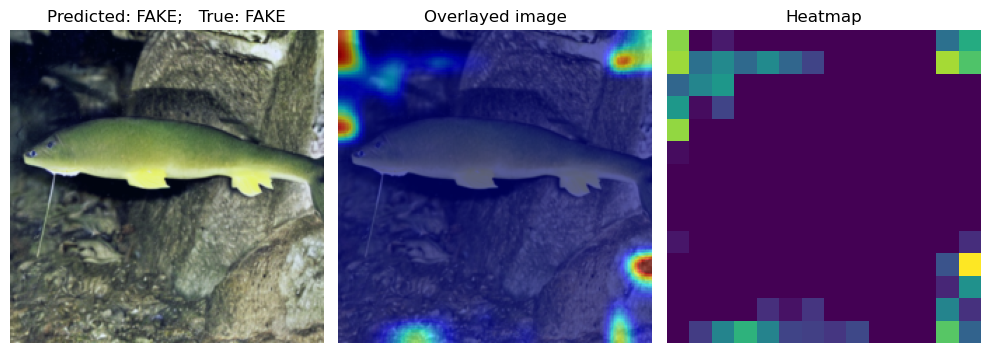

In [26]:
model = models.multiclass_untrained()
model.load_state_dict(torch.load('./weights/multiclass_untrained_batch64_epochs7.pth'))
sample_idx = torch.randint(len(train_ds), size=(1,)).item()
print(sample_idx)
gradcam.plot_gradcam_multioutput(model, model.features[6][-1], train_ds, binary_labels_map, 'binary', sample_idx)
gradcam.plot_gradcam_multioutput(model, model.features[6][-1], train_ds, multiclass_labels_map, 'multiclass', sample_idx)

Forward hook running...
Activations size: torch.Size([1, 256, 14, 14])
Forward hook running...
Activations size: torch.Size([1, 256, 14, 14])
Backward hook running...
Gradients size: torch.Size([1, 256, 14, 14])
Backward hook running...
Gradients size: torch.Size([1, 256, 14, 14])
Forward hook running...
Activations size: torch.Size([1, 256, 14, 14])


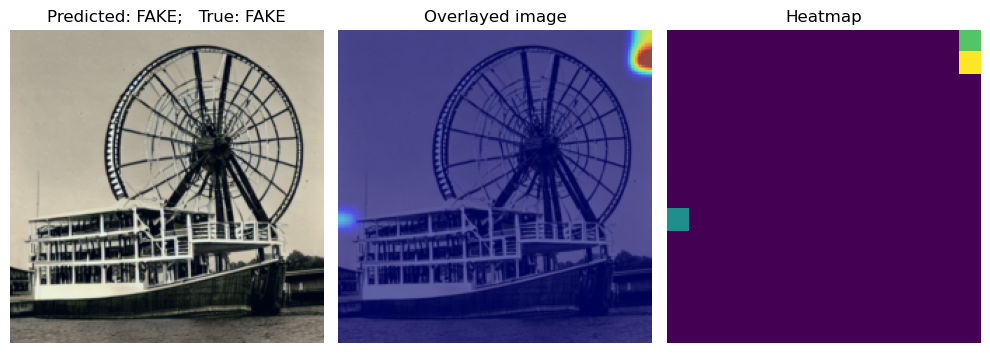

Forward hook running...
Activations size: torch.Size([1, 256, 14, 14])
Forward hook running...
Activations size: torch.Size([1, 256, 14, 14])
Backward hook running...
Gradients size: torch.Size([1, 256, 14, 14])
Backward hook running...
Gradients size: torch.Size([1, 256, 14, 14])
Forward hook running...
Activations size: torch.Size([1, 256, 14, 14])


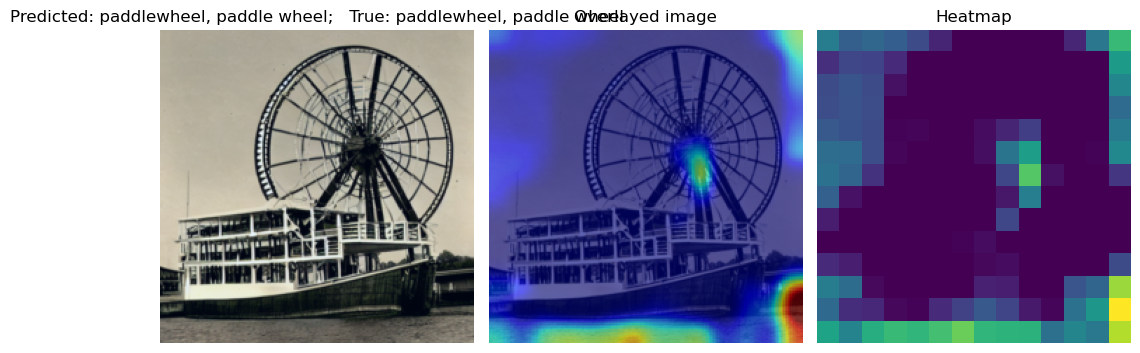

In [28]:
sample_idx = 112572
gradcam.plot_gradcam_multioutput(model, model.features[6][-1], train_ds, binary_labels_map, 'binary', sample_idx)
gradcam.plot_gradcam_multioutput(model, model.features[6][-1], train_ds, multiclass_labels_map, 'multiclass', sample_idx)

In [13]:
print(model)

MultioutputResNet34(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin